[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UBi-courses/essentials-bioinformatics-2025/blob/main/practicos/day2/2BC_Long_Read_Quantification/practico2C_colab.ipynb)



# 🧮 Practical 2C - Long-Read Transcriptomics Quantification and DE - DTU (Google Colab)

This notebook guides you through a student-friendly pipeline for long-read RNA-seq analysis of ONT cDNA data, using **bambu**.  

**Please read the quick rules:**  
- **Each student must make their own copy in their own Drive**: *File → Save a copy in Drive*.  
- **Run cells from top to bottom.** If the runtime disconnects, re-run the setup cells (Drive mount, installs).  
- We are using smaller datasets (e.g. sliced for one chromosome).
- We will be working with the R kernel in Google Colab. To enable it, go to `Runtime → Change runtime type`, and choose R as the kernel.




## Student checklist (start here)
- ✅ Open this notebook link and do **File → Save a copy in Drive** (work on your own copy).
- ✅ Keep **paths** consistent: edit them if necessary.
- ✅ If you see `ModuleNotFoundError` or `command not found`, re-run the **Install tools** cell.
- ✅ In Colab you can see your file system explorer. By default, Google Colab starts in the `/content` directory. This is the root directory where you can perform various operations.

## About this exercise

In addition to `wf-transcriptomics`, there are other pipelines such as [nf-core/nanoseq](https://github.com/nf-core/nanoseq).
**nanoseq** is a bioinformatics pipeline for Nanopore DNA/RNA sequencing data, capable of performing basecalling, demultiplexing, QC, alignment, and downstream analyses. It is built using Nextflow and containerized with Docker/Singularity, ensuring easy installation and reproducibility.

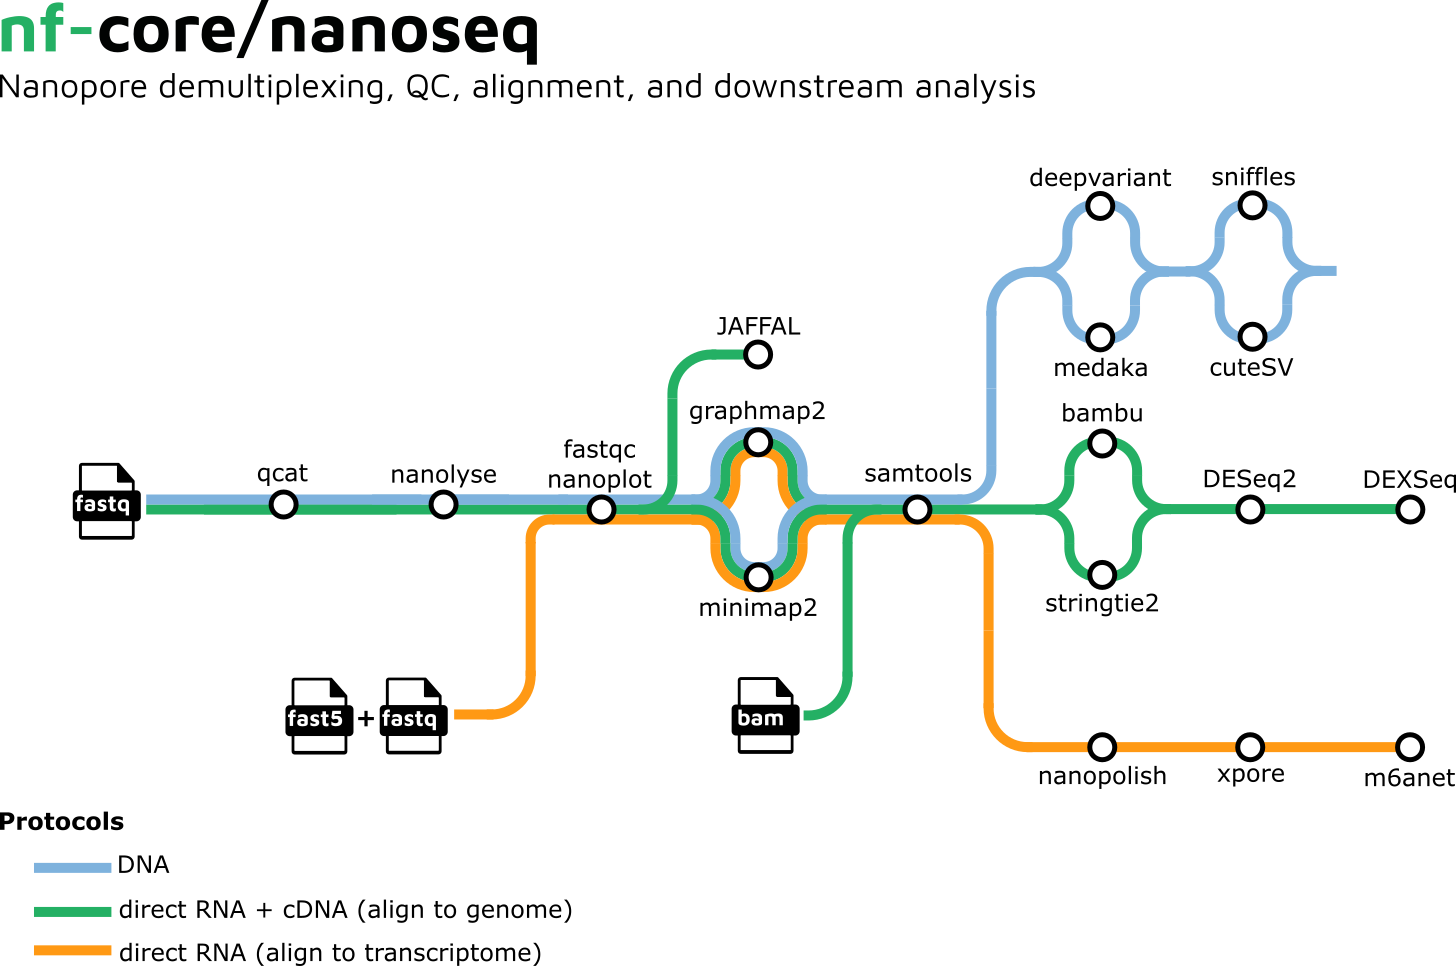

This pipeline is associated with the SG-NEx dataset that we have been exploring. For this exercise, however, we will only use the [bambu](https://www.bioconductor.org/packages/release/bioc/html/bambu.html) ([Chen et al., 2023](https://www.nature.com/articles/s41592-023-01908-w)) tool for transcript quantification and analysis.


In this tutorial, we will use Bambu to perform novel transcript discovery and quantification on a reduced dataset from the SG-NEx project. The dataset includes six Nanopore direct RNA-seq samples, with three replicates each from the A549 (lung cancer) and HepG2 (liver cancer) human cell lines. For demonstration purposes, we will work with a subset of reads aligned to chromosome 22. We will demonstrate how to apply bambu to these bam files to identify novel transcripts and estimate transcript expression levels, visualize the results, and identify differentially expressed genes and transcripts.


## 0) Datasets to be used
Because we are working with the R kernel, mounting Google Drive is less straightforward. Here, we will simply upload the necessary files from the local machine. The code to retrieve the files from AWS is shown below for reference — **please do not run it**.

In [ ]:
## install AWS for R
#install.packages("aws.s3")
## set region for AWS
#Sys.setenv("AWS_DEFAULT_REGION" = 'ap-southeast-1')

In [ ]:
## create a directory to store the data
#dir.create("bambu_tutorial")
## download genome fasta file
#aws.s3::save_object(
#  object="data/data_tutorial/annotations/hg38_chr22.fa",
#  bucket="sg-nex-data",
#  file="./bambu_tutorial/hg38_chr22.fa")
## download genome index fastai file
#aws.s3::save_object(
#  object="data/data_tutorial/annotations/hg38_chr22.fa.fai",
#  bucket="sg-nex-data",
#  file="./bambu_tutorial/hg38_chr22.fa.fai")
## download gtf file
#aws.s3::save_object(
#  object="data/data_tutorial/annotations/hg38_chr22.gtf",
#  bucket="sg-nex-data",
#  file="./bambu_tutorial/hg38_chr22.gtf")
## download aligned bam files for A549 samples and HepG2 samples
#bam_list=c("A549_directRNA_sample1.bam",
#           "A549_directRNA_sample2.bam",
#           "A549_directRNA_sample3.bam",
#           "HepG2_directRNA_sample1.bam",
#           "HepG2_directRNA_sample2.bam",
#           "HepG2_directRNA_sample3.bam")
##for (bam in bam_list){
#  aws.s3::save_object(
#    object=paste0("data/data_tutorial/bam/",bam),
#    bucket = "sg-nex-data",
#    file=paste0("./bambu_tutorial/",basename(bam)))
#}


## 1) Upload required files from local computer

The required data include:

*   a set of aligned reads to the genome from the A549 and HepG2 cell lines (bam files; sliced bam to chr22)
*   reference human genome annotations (gtf file; chr22)
*   reference human genome sequence (fasta file; chr22)

The files are located at **`/mnt/lab/Data/day2/practical2/bambu_tutorial/`**


## 2) Install bambu (run once per fresh session)
First, we have to install **bambu** and dependencies. It takes some minutes...

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("bambu", update = FALSE)

In [ ]:
install.packages("circlize")
BiocManager::install("ComplexHeatmap")
BiocManager::install("ggbio")

## 3) Prepare data for running bambu



💡 Although we already have the aligned reads in BAM format, Bambu also needs access to the genome FASTA file.
**Question**: Why do you think this additional file is necessary? (*Think about how the genome sequence can be used to correct or validate splicing junctions.*)

`bambu` also requires a reference transcript annotations object, which is used to correct read alignments, to train a model for transcript discovery, and for quantification. The annotation object can be created from a gtf file.

In [ ]:
#load library
library(bambu)
library(ggplot2)


In [ ]:
# set work directory if you are in a different directory
setwd("bambu_tutorial")

# data preparation
fa.file <- "hg38_chr22.fa"
gtf.file <- "hg38_chr22.gtf"
annotations <- prepareAnnotations(gtf.file)
my.bam <- ("A549_directRNA_sample1.bam")
samples.bam <- list.files(".", pattern = ".bam$", full.names = TRUE)

The function `prepareAnnotations` creates a reference annotation object which is used for transcript discovery and quantification in bambu. Inspect the object `annotations`. What is its content?

In [ ]:
annotations


## 4) Transcript discovery
Next we apply `bambu` on the input data (one of the bam files, annotations, genome sequence). Bambu will perform isoform discovery to extend the provided annotations, and then quantify the transcript expression from these extended annotations using an Expectation-Maximisation algorithm.

🧩 Run `bambu` to identify new transcripts and quantify them.
👉 **Question**: What is the meaning of `NDR`?


In [ ]:

se.sample1 <- bambu(reads = my.bam, annotations = annotations, genome = fa.file,
    ncore = 2, opt.discovery = list(fitReadClassModel = FALSE), NDR=0.1)

🧩 Inspect the `se.sample1` object. Were any new transcripts discovered? How many?

In [ ]:
se.sample1

In [ ]:
length(annotations)

Optionally, users can choose to apply `bambu` to do transcript discovery only or to apply `bambu` to do quantification only (without isoform discovery).




## 5) Running multiple samples

If you have multiple replicates for a sample, or plan to do comparative analysis between conditions, it may be beneficial to run all samples together instead of individually. This can be done by providing a vector of paths to all the bam files you want to analyze together.

The advantage of running samples together include: novel transcripts that are identified in multiple samples are assigned unified IDs, enabling comparative analysis between different samples. This is especially important for downstream differential expression analysis when looking at novel transcripts.


🧩 Run `bambu` for all six samples.

In [ ]:

se <- bambu(reads = samples.bam, annotations = annotations, genome = fa.file,
    ncore = 2, opt.discovery = list(fitReadClassModel = FALSE), NDR=0.1)

## 6) Inspecting and saving the results

As we saw earlier, `bambu` returns a `SummarizedExperiment` object with the genomic coordinates of the annotated & novel transcripts and their expression estimates. They can be assessed using the following code:


In [ ]:
se

In [ ]:
assays(se) #returns the different contents


In [ ]:
#to see dimensions of counts
dim(assays(se)$counts)
#to see the first rows
head(assays(se)$counts)

In [ ]:
#returns a GRangesList (with genomic coordinates) with all annotated and newly discovered transcripts.
rowRanges(se)

In [ ]:
#returns additional information about each transcript such as the gene name and the class of the newly discovered transcript.
rowData(se)

This `SummarizedExperiment` object can also be used for further downstream analysis (eg. `DESeq2`). If you want to save the transcript & genomic annotations and their expression estimates, you can then write them into an output folder using the `writeBambuOutput` function.

In [ ]:
writeBambuOutput(se, path = "./output", prefix="tutorial_")

What are the new files saved in `./output`?

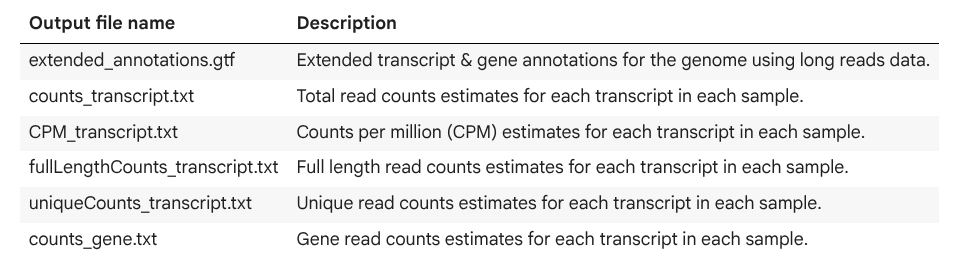

`bambu` also includes a function that only exports the extended annotations to gtf file:

In [ ]:
save.file <- file.path("./output", "bambu_extended_annot.gtf")
writeToGTF(rowRanges(se), file = save.file)
#file idem to extended_annotations.gtf

## 7) Visualizing the results




In [ ]:
plotBambu(se, type = "heatmap")

In [ ]:
plotBambu(se, type = "pca")

<font color="blue">

For the downstream analysis, we will add the **condition of interest** to the object that describes the samples. This variable will later be used for differential expression analysis, and it can also be used now to color the samples in the PCA. </font>
To do so, we first include the variable in the `se` object and then use the `group.var` argument in the `plotBambu()` function to visualize the groups.

In [ ]:
#to have a look on sample names
colnames(colData(se))
colData(se)

In [ ]:
#create factor with grouping variable
colData(se)$cellLine <- factor(c(rep("A549",3),rep("HepG2",3)))
colData(se)

In [ ]:
plotBambu(se, type = "pca", group.var = "cellLine")

In addition to visualising the correlation between samples, bambu also provide a function to visualise the extended annotation and expression estimation for individual genes. Here we look at gene ENSG00000223875 and visualise the transcript coordinates for annotated and novel isoforms and expression levels for these isoforms across all samples.

In [ ]:
plotBambu(se, type = "annotation", gene_id = "ENSG00000223875")


## 8) Obtain gene expression estimates from transcript expression

To obtain the accurate gene expression estimates which uses all reads that can be assigned to each gene (including reads that are incompatible with all existing annotations) you can run the following command.

In [ ]:
seGene <- transcriptToGeneExpression(se)
seGene

Looking at the output, do we identified novel genes?

We can again use the function to visualise the gene expression data across the 6 samples with a heatmap or PCA plot.

🧩 **Question**: After summarizing expression to the gene level, do the samples from each cell line group more tightly together in the PCA and heatmap?
What might explain this difference compared to transcript-level quantification?

In [ ]:
colData(seGene)

In [ ]:
plotBambu(seGene, type = "heatmap")

In [ ]:
plotBambu(seGene, type = "pca", group.var = "cellLine")


## 9) Install downstream tools


In [ ]:
BiocManager::install("DESeq2")
BiocManager::install("apeglm")
BiocManager::install("DRIMSeq")


## 10) Identifying differentially expressed genes with DESeq2

One of the most common tasks when analysing RNA-Seq data is the analysis of differential gene expression across a condition of intertest. Here we use **DESeq2** to find the differentially expressed genes between A549 and HepG2 cells.

[DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) ([Love et al., 2014](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8)) is an R/Bioconductor package for differential gene expression analysis using count data such as RNA-seq. It models the read counts with a negative binomial distribution, estimates the dispersion for each gene, and applies empirical shrinkage to stabilize fold-change estimates — especially useful when the number of replicates is small.
Statistical tests (Wald test or likelihood ratio test) are then used to identify genes that show significant expression changes between conditions.

In [ ]:
library(DESeq2)
dds <- DESeqDataSetFromMatrix(round(assays(seGene)$counts), colData = colData(se),
    design = ~cellLine)
dds <- DESeq(dds)
deGeneRes <- DESeq2::results(dds, independentFiltering = FALSE)
head(deGeneRes[order(deGeneRes$padj), ])

A quick summary of differentially expressed genes:

In [ ]:
summary(deGeneRes)

We can also visualize the **MA-plot** for differentially expressed genes. However, MA-plots based on the original log2 fold change values are affected by the noise associated with low-count genes. As recommended in the DESeq2 tutorial, we applied apeglm shrinkage to the effect sizes to obtain more accurate and stable log2 fold change estimates.

In [ ]:
resultsNames(dds)

In [ ]:
deGeneRes.apeglm <- lfcShrink(dds, coef = "cellLine_HepG2_vs_A549", type = "apeglm")
plotMA(deGeneRes.apeglm, ylim = c(-3, 3))

❓ **Question**: How would the results change if you performed the differential expression analysis at the transcript level?
Try running the analysis and compare it with the gene-level results.

## 11) A first approximation to differential transcript usage
As a first step toward identifying **differential transcript usage (DTU)**, we will evaluate which genes show changes in the relative expression of their transcripts across conditions. This analysis can reveal isoform-level regulatory changes that may occur even when total gene expression remains constant.
To perform this analysis, we will use the **DRIMSeq** package from Bioconductor.

[DRIMSeq](https://bioconductor.org/packages/release/bioc/html/DRIMSeq.html) ([Nowicka & Robinson, 2016](https://f1000research.com/articles/5-1356/v2)was designed to detect differential transcript usage by modeling transcript counts within genes using a Dirichlet-multinomial distribution.
This model accounts for biological variability and the compositional nature of transcript proportions.
`DRIMSeq` tests whether the proportion of reads assigned to each transcript differs between conditions, rather than testing total expression changes. This makes it particularly useful for studying isoform switching and other forms of transcript-level regulation that are not captured by traditional differential gene expression analyses.

In [ ]:
library(DRIMSeq)
library(dplyr)


## Use the transcript-level SummarizedExperiment (bambu output)
## se: rows = transcripts, cols = samples
## rowData(se)$gene_id  -> gene for each transcript
## rownames(se)         -> transcript (feature) IDs
## assays(se)$counts    -> transcript-level counts

# 1) Samples/colData
samples <- data.frame(
  sample_id = colnames(se),
  cellLine  = factor(colData(se)$cellLine)  # e.g., levels: A549, HepG2
)

# (optional) set reference level to match your DESeq2 setup
samples$cellLine <- relevel(samples$cellLine, ref = "A549")

# 2) Counts data.frame for DRIMSeq: gene_id, feature_id, then sample columns
counts_df <- cbind(
  data.frame(
    gene_id    = as.character(rowData(se)$GENEID),
    feature_id = rownames(se)
  ),
  as.data.frame(round(assays(se)$counts))   # integer counts
)



In [ ]:
# 3) Build DRIMSeq object
d <- dmDSdata(counts = counts_df, samples = samples)

# 4) Basic filtering (tune thresholds to your data size)
d <- dmFilter(
  d,
  min_samps_feature_expr = 3,  # feature (transcript) expressed in ≥3 samples
  min_feature_expr       = 10, # ≥10 counts
  min_samps_gene_expr    = 3,  # gene expressed in ≥3 samples
  min_gene_expr          = 10
)

# 5) Design, precision, fit, test
design_full <- model.matrix(~ cellLine, data = DRIMSeq::samples(d))

d <- dmPrecision(d, design = design_full)
d <- dmFit(d, design = design_full)

# Test DTU; the coefficient name depends on your factor levels
# Check colnames(design_full) or use coef=2 if it's the second column
d <- dmTest(d, coef = "cellLineHepG2")

# 6) Results
res.gene <- DRIMSeq::results(d)                 # gene-level DTU p-values
res.tx   <- DRIMSeq::results(d, level = "feature") # transcript-level contributions



In [ ]:
# Quick look
head(res.gene[order(res.gene$adj_pvalue), ], 10)
head(res.tx[order(res.tx$adj_pvalue), ], 10)

❓ **Questions**: How many genes show DTU considering adjusted pvalue < 0.1? How many transcripts are involved?


Let's now take a look at how transcript usage differs between cell lines for one of the significant genes.

In [ ]:
sig_gene <- "ENSG00000100138"

In [ ]:
# 1) Get proportions (wide) and filter the gene
prop_wide <- DRIMSeq::proportions(d) %>%
  dplyr::filter(gene_id == sig_gene)

# 2) Wide -> long: sample columns become rows
prop_long <- prop_wide %>%
  tidyr::pivot_longer(
    cols = -c(gene_id, feature_id),
    names_to = "sample_id",
    values_to = "proportion"
  )

# 3) Add sample metadata (e.g., cellLine) from DRIMSeq object
samp <- DRIMSeq::samples(d) %>% as.data.frame()
prop_long <- prop_long %>%
  dplyr::left_join(samp, by = "sample_id") %>%
  tidyr::replace_na(list(proportion = 0))


In [ ]:
# 4) Condition-level mean usage (cleaner overview)
prop_mean <- prop_long %>%
  group_by(cellLine, feature_id) %>%
  summarise(mean_prop = mean(proportion, na.rm = TRUE), .groups = "drop")

ggplot(prop_mean, aes(x = feature_id, y = mean_prop, fill = cellLine)) +
  geom_col(position = "dodge") +
  theme_bw() +
  labs(
    title = paste("Mean transcript usage by condition for", sig_gene),
    x = "Transcript (feature_id)", y = "Mean proportion"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))